In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.special as sp
import scipy.stats as st
import numpy as np

%matplotlib inline
plt.style.use('seaborn')

# Bayesian Methods
##### October 19, 2017

In this notebook we will discuss Bayes' Rule and its application to Bayesian inference.

## Table of Contents
* Bayes' Rule
  * Conditional Probability and the Prosecutor's Fallacy
* Priors and Posteriors
* Conjugate Priors
* Bayesian versus Frequentist Viewpoints
* MCMC and Posterior Sampling

## Bayes' Rule
#### Prosecutor's Fallacy
Consider a man accused of a crime in New York, with a matching DNA profile. The chance of DNA profiles matching is only 1 in 1 million. Since this evidence seems to overwhelmingly point toward guilt, a prosecutor then argues for his conviction.

However, there is a fallacy in this reasoning: Suppose $A$ is the event that the suspect is innocent, and $B$ is the event that the DNA profiles match. Then, the evidence we have is that $P(B|A)$ - the probability that the DNA profiles match despite a suspect's innocence - is very low. However, this is not the same as $P(A|B)$.

Instead, the "correct" relationship is given by _Bayes' Rule_: From the definition of conditional probability, we have that

$$\Pr(A\ |\ B) = \frac{\Pr(A)\Pr(B\ |\ A)}{\Pr(B)}.$$

New York has a population of about 8.5 million. Thus, the probability that the suspect is guilty comes out to around 10% - quite low now!

## Priors and Posteriors
We can apply this rule to in order to perform statistical inference. Suppose we have a random variable, $X$, with a distribution (say, binomial) controlled by one or more given parameters.

For instance, consider flipping a (possibly weighted) coin. Then, the number of heads after $n$ flips is a binomial distribution parameterized by $\theta$, which is the probability of a single flip giving heads.

To perform Bayesian inference, we need a _prior_ distribution. This distribution may be based on domain knowledge or a "prior belief" - otherwise, we often use a uniform (or _flat_) prior. This choice is subjective; however, in statistics, all inferences must be based on some assumption.

Given a prior distribution for $\theta$, let $X$ represent the observed data after $n$ flips. After taking our observations into account, we can then form a _posterior_ distribution for $\theta$, based on both the data and our prior distribution, by using Bayes' Rule:

$$\Pr(\theta\ |\ X) = \frac{\Pr(\theta) \ L(\theta\ |\ X)}{\Pr(X)}.$$

Here, $L(\theta \ |\ X)$ is the _likelihood_ of $\theta$ given $X$; defined by $L(\theta \ |\ X) = \Pr(X \ |\ \theta)$. This is the same likelihood function used in MLE, for instance.

For continuous distributions, we'll use densities instead:

$$f(\theta\ |\ X) = \frac{f(\theta) \ L(\theta\ |\ X)}{\Pr(X)}.$$

#### Coin Flipping Example
Let's consider our coin flipping example, with the following prior distribution and observations:
* We'll assume that $\theta$ is uniformly distributed on the set $\{0.1, 0.2, \dots, 0.9\}$.
* After flipping the coin 5 times, we have obtained 4 heads and 1 tail.

Then, the _prior_ probability distribution has the following shape:

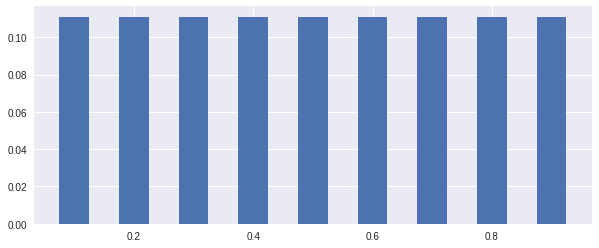

In [18]:
plt.figure(figsize=(10, 4))
x = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
y = np.array([0.111, 0.111, 0.111, 0.111, 0.111, 0.111, 0.111, 0.111, 0.111])
plt.bar(x, y, width=0.05)
plt.show()

To compute the likelihood seeing our data at each value of $\theta$, we use the binomial pdf:
* Given $\theta = 0.1$, the likelihood of 4 heads and 1 tails is $\binom{5}{4} (0.1)^4 (0.9) = 4.5 \times 10^{-4}$.
* Given $\theta = 0.2$, the likelihood of 4 heads and 1 tails is $\binom{5}{4} (0.2)^4 (0.8) = 6.4 \times 10^{-3}$.
* and so on...

The graph of the likelihood function $L(\theta \ |\ X)$ is as follows:

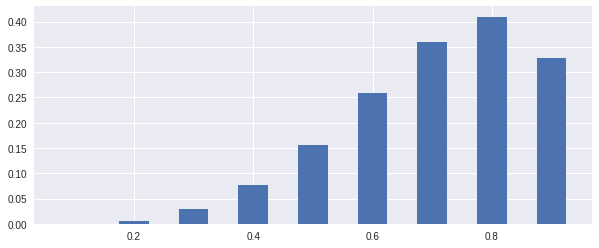

0.180583333333


In [20]:
plt.figure(figsize=(10, 4))
x = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
y = 5 * (x ** 4) * (1 - x)
plt.bar(x, y, width=0.05)
plt.show()

The _normalizing constant_, $\Pr(X)$, is computed by the law of total probability:

$$\Pr(X) = \sum_{x\in X} \Pr(\theta)\ L(\theta\ |\ X).$$ We can find it as follows:

In [21]:
print(sum(y) / 9)

0.180583333333


Thus, the _posterior probability_ is found by multiplying the likelihood function of each $\theta$ with the prior probability, and then dividing by the normalizing constant. The posterior distribution then has the following shape:

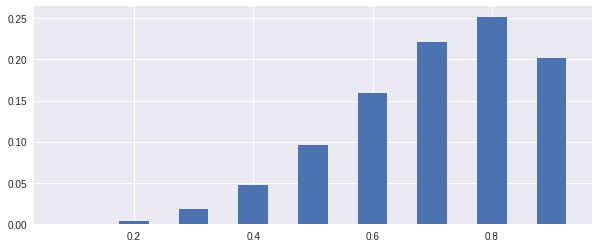

In [22]:
plt.figure(figsize=(10, 4))
x = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
y = 5 * (x ** 4) * (1 - x)
y = y / sum(y)
plt.bar(x, y, width=0.05)
plt.show()

In particular, notice that while our _prior_ probability gave an equal weight to each value, once we have flipped the coin 5 times and obtained such a skewed distribution, our beliefs have shifted toward $\theta$ being larger.

## Conjugate Priors
Notice that our previous prior was discrete: We believed that $\theta$ could only be 0.1, 0.2, etc. In practice, this is probably not a very good prior. Instead, it's more natural to believe that the coin weights can assume values anywhere on the continuous interval $(0, 1)$.

However, this creates a new difficulty: Notice how annoying the normalizing constant was to compute, even with the simplest possible scenario. If we assume that $\theta$ assumes a continuous distribution, then the normalizing constant is given by the integral:

$$\Pr(X) = \int 5 \cdot \theta^4 (1 - \theta)^{-1} f(\theta) \ d\theta$$.

This integral can be very intractable, depending on the choice of prior AND the observed data. Luckily, there is a choice of prior that makes finding the posterior distribution easy, no matter what data is observed!

The __beta distribution__ is given by the following PDF:

$$\operatorname{Beta}(\alpha, \beta) \propto x^{\alpha - 1} (1 - x)^{\beta - 1}$$

where the proportionality constant is found using the __beta__ function. In particular, $\operatorname{Beta}(1, 1)$ is the uniform distribution on $[0, 1]$.

We can show the following fact: __If likelihood function is a binomial pdf, and the prior is a beta distribution, then the posterior is another beta distribution__. Or, in other words, the beta distribution is _conjugate_ to the binomial distribution.

* Assume that we have observed $a$ heads and $b$ tails.
* Then, assume $\theta$ has a prior distribution of $\operatorname{Beta}(\alpha, \beta)$.
* We can show that the posterior distribution of $\theta$ is then $\operatorname{Beta}(\alpha + a, \beta + b)$.

Finally, this conjugate distribution has a natural interpretation: We can interpret a prior of $\operatorname{Beta}(\alpha, \beta)$ as having _prior_ seen $\alpha$ heads and $\beta$ tails.

* Recall that $\operatorname{Beta}(1, 1)$ is a uniform distribution on [0, 1]. Seeing one head and one tail says little about where $\theta$ can be.
* Let's now graph the prior distribution $\operatorname{Beta}(5, 5)$ - equivalent to having seen 5 heads and 5 tails "prior"

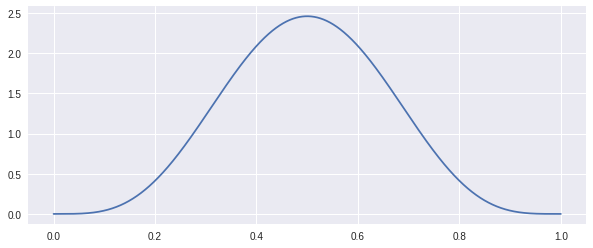

In [26]:
plt.figure(figsize=(10, 4))
x = np.linspace(0, 1, 10000)
y = (x ** 4) * ((1 - x) ** 4) / sp.beta(5, 5)
plt.plot(x, y)
plt.show()

This distribution is more concentrated around 0.5, reflecting an increased prior confidence that the coin is, in fact, fair.

#### Posterior Distributions
We can see how our choice of prior affects our posterior distribution. Let's take our case of 5 flips, with 4 heads and 1 tails.

* The blue graph is the posterior distribution under the prior $\operatorname{Beta}(1, 1)$.
* The green graph is the posterior distribution under the prior $\operatorname{Beta}(5, 5)$.

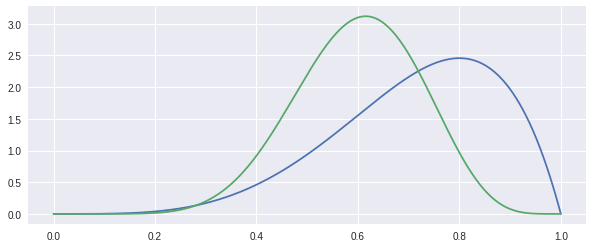

In [29]:
plt.figure(figsize=(10, 4))
x = np.linspace(0, 1, 10000)
y1 = (x ** 4) * ((1 - x) ** 1) / sp.beta(5, 2)
y2 = (x ** 8) * ((1 - x) ** 5) / sp.beta(9, 6)
plt.plot(x, y1, c='C0')
plt.plot(x, y2, c='C1')
plt.show()

* Since a $\operatorname{Beta}(1, 1)$ prior reflects a _low_ confidence in the coin being fair, the posterior distribution is far more concentrated around 0.8 - the value reflected by our data.
* However, a prior of $\operatorname{Beta}(5, 5)$ reflects a _high_ initial confidence in a fair coin; hence, with only 5 flips worth of data, the posterior difference hasn't budged as much from its original center at 0.5.

Now, assume we have made 500 coin flips, with 400 heads and 100 tails. Now, the respective posterior distributions are as follows:

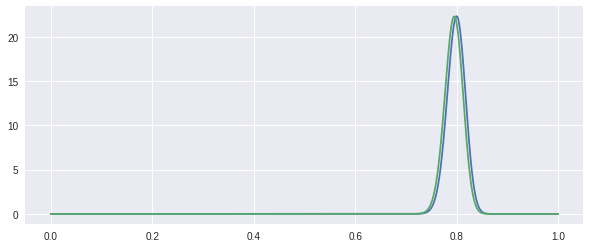

In [30]:
plt.figure(figsize=(10, 4))
x = np.linspace(0, 1, 10000)
y1 = (x ** 400) * ((1 - x) ** 100) / sp.beta(401, 101)
y2 = (x ** 404) * ((1 - x) ** 104) / sp.beta(405, 105)
plt.plot(x, y1, c='C0')
plt.plot(x, y2, c='C1')
plt.show()

Not only are both posteriors heavily concentrated around 0.8, but they are quite similar. With enough data, the prior's importance is much lower.

#### Other Conjugate Priors
* Poisson likelihood function: $\operatorname{Gamma}(\alpha, \beta)$ representing $\alpha$ total occurrences in $\beta$ intervals.
* Normal likelihood function: Normal prior on the mean, inverse gamma prior on the variance (more complicated).
  * Best done with computer software.

## Bayesian versus Frequentist Viewpoints
Let's take a moment to discuss the difference between Bayesian and Frequentist methods.

In the _frequentist_ view, probability is interpreted via a limit of proportions:
* The $p$-value is the proportion of trials that have outcomes as extreme as our observed outcome, as we take many trials.
* In particular, this requires an assumption of a "null" hypothesis, in order to obtain a conditional probability of obtaining our data.
* "Frequentist" refers to repeating the same experiment, the most natural interpretation of our conditional probability given hypothesis.

In the _Bayesian_ view, probability is interpreted as a quantification of belief:
* Bayesian inference requires having a prior belief. This is just that - a belief.
* As more data is obtained, we obtain a new belief each time. The first few data points may not affect our belief very much, but as we obtian more data, our beliefs will reflect the data we are observing.

##### Isn't this whole "prior" thing subjective? How is this different than guessing.
Ultimately, in statistics we have to make some assumptions, somewhere. When it comes to frequentist statistics, these assumptions are not as clear (so we may think there are none). However, these assumptions come in the form of:
* Choice of null hypothesis.
* Choice of $p$-value cutoff (which may be very different than the power of our test).

## Posterior Sampling Methods
While conjugate priors provide a simple means of obtaining a posterior distribution, not all likelihood functions have conjugate priors! In this case, finding the posterior distribution requires evaluating the normalizing constant given by the integral
$$\int f(\theta)\ L(\theta\ |\ X = x) \ dx.$$
Unfortunately, these integrals do not usually have closed form solutions; thus, analytical techniques are required.

In fact, it was only recently that Bayesian methods become very popular, due to the new compute power that has allowed us to approximate these integrals! The algorithm we will use is known as _Metropolis-Hastings Algorithm_, with a high-level overview as follows:

We'll apply posterior sampling to our coin flip example. Suppose we have made 200 coin flips, with 120 heads and 80 tails, and assume a uniform prior. Then, the posterior distribution can be sampled as follows:

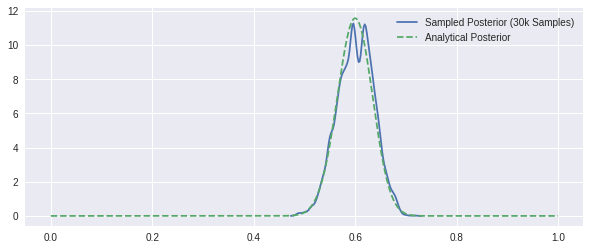

In [62]:
samples = np.zeros(30000)
current = 0.5
current_lh = 0.5 ** 200
for _ in xrange(2000):
    proposal = st.beta.rvs(0.5 * current, 0.5 * (1 - current), size=1)[0]
    proposed_lh = (proposal ** 120 * (1 - proposal) ** 80)
    if (proposed_lh / current_lh) >= np.random.uniform():
        current = proposal
        current_lh = proposed_lh
    
for i in xrange(30000):
    proposal = st.beta.rvs(0.5 * current, 0.5 * (1 - current), size=1)[0]
    proposed_lh = (proposal ** 120 * (1 - proposal) ** 80)
    if (proposed_lh / current_lh) >= np.random.uniform():
        current = proposal
        current_lh = proposed_lh
    samples[i] = current

plt.figure(figsize=(10, 4))
x = np.linspace(0, 1, 10000)
y = (x ** 120) * ((1 - x) ** 80) / sp.beta(121, 81)
sns.kdeplot(samples, label='Sampled Posterior (30k Samples)')
plt.plot(x, y, linestyle='--', label='Analytical Posterior')
plt.legend()
plt.show()